# Notebook to Go Through the Steps in Calculating the Boundary Conditions #
## Juan de Fuca Strait ##

In [1]:
import gsw
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import PyCO2SYS as pyco2
import xarray as xr

### Choose our Day (September 8, 2015 and our profile #10)
Read in the LiveOcean Boundary Conditions

In [2]:
ds = xr.open_dataset('/results/forcing/LiveOcean/boundary_conditions/LiveOcean_v201905_y2015m09d08.nc')

# Calculate Sigma
ds['sigma'] = gsw.sigma0(ds.vosaline, ds.votemper)
ds.sigma.attrs['long_name'] = 'Sigma at surface'
ds.sigma.attrs['units'] = 'kg/m3'
# Change DIC, TA and OXY to umol/kg from mmol/m3
# any value in mmol/m3 to umol/kg requires
#mmol/m3 * m3/((1000+sigma)kg)*(1000umol/mmol)
conversion_uMolar_to_umolkg = 1000 / (1000 + ds.sigma)

ds['DIC_uMol'] = ds.DIC
save_attrs = ds.DIC.attrs
ds['DIC'] = ds.DIC * conversion_uMolar_to_umolkg
save_attrs['units'] = 'umol/kg'
ds.DIC.attrs = save_attrs

save_attrs = ds.TA.attrs
ds['TA'] = ds.TA * conversion_uMolar_to_umolkg
save_attrs['units'] = 'umol/kg'
ds.TA.attrs = save_attrs

save_attrs = ds.OXY.attrs
ds['OXY'] = ds.OXY * conversion_uMolar_to_umolkg
save_attrs['units'] = 'umol/kg'
ds.OXY.attrs = save_attrs

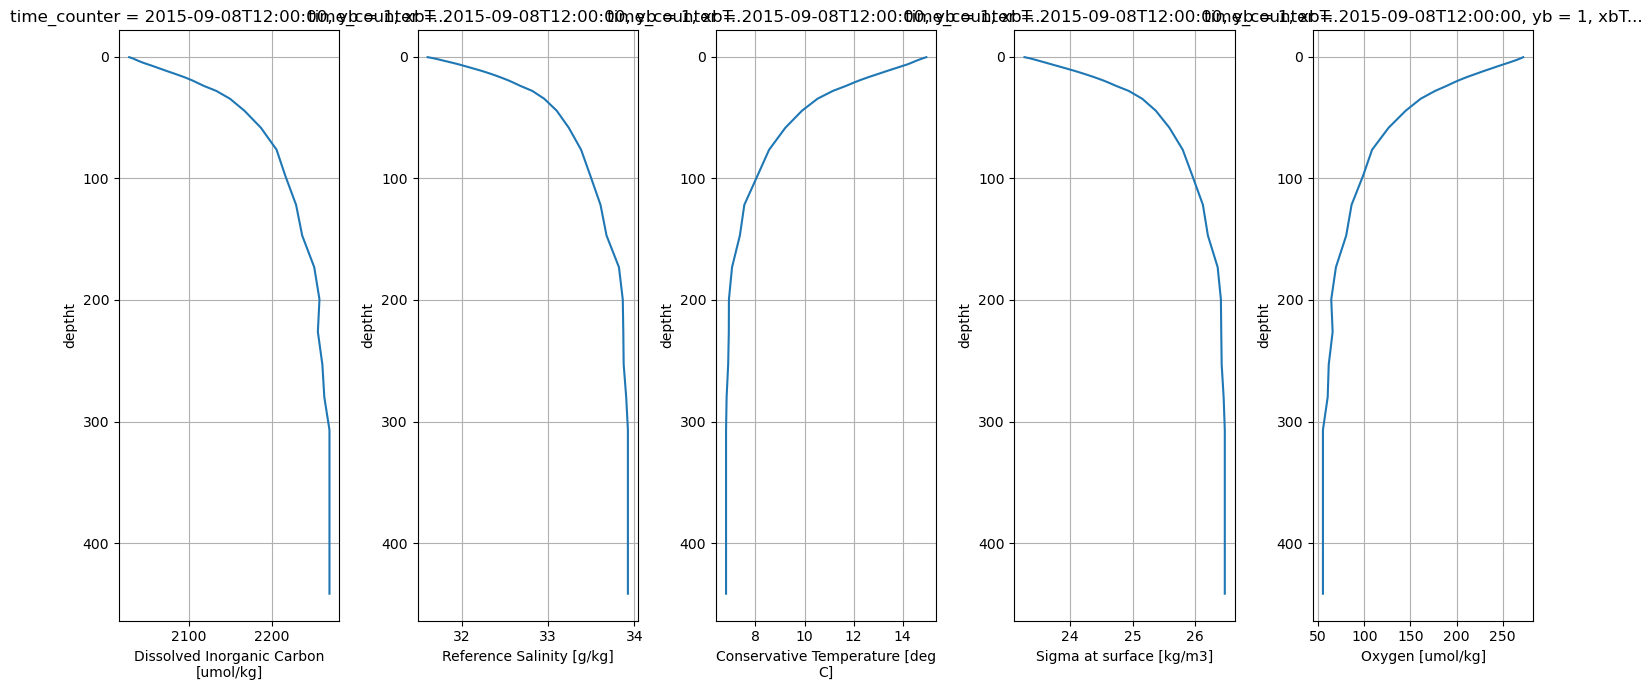

In [3]:
# Plot
fig, axs = plt.subplots(1, 5, figsize=(15, 7))
ds.DIC[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.vosaline[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);
ds.votemper[0, :, 0, 10].plot(ax = axs[2], y='deptht', yincrease=False);
ds.sigma[0, :, 0, 10].plot(ax = axs[3], y='deptht', yincrease=False);
ds.OXY[0, :, 0, 10].plot(ax = axs[4], y='deptht', yincrease=False);

for ax in axs:
    ax.grid()
fig.tight_layout();

## Step 1 Find when isopycnal last at surface

In [4]:
# parameters for fit
params0 = 0.1301889490932413
params1 = 3.8509914822057825
params2 = 8.301166081413104 #change to 2015 since model year is 2015

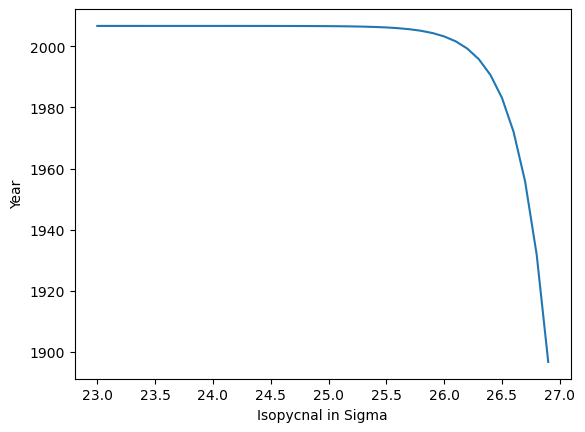

In [5]:
# plot
ssigmas = np.arange(23, 27, 0.1)
pycnal_last_at_surface = 2015 - (params0 * np.exp(-params1 * (25.15 - ssigmas)) + params2)
plt.plot(ssigmas, pycnal_last_at_surface);
plt.ylabel('Year')
plt.xlabel('Isopycnal in Sigma');

Image with the Data 
![title](../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/FigureS8_Jarnikova_PI.png)

I note that the fit is poor for sigma < 25: but we don't use it for that, so all okay

In [6]:
# calculate when the isopycnals were last at the surface
ds['pycnal_last_at_surface'] = 2015 - (params0 * np.exp(-params1 * (25.15 - ds.sigma)) + params2)
ds.pycnal_last_at_surface.attrs['long_name'] = 'Surface Date'
ds.pycnal_last_at_surface.attrs['units'] = 'year'

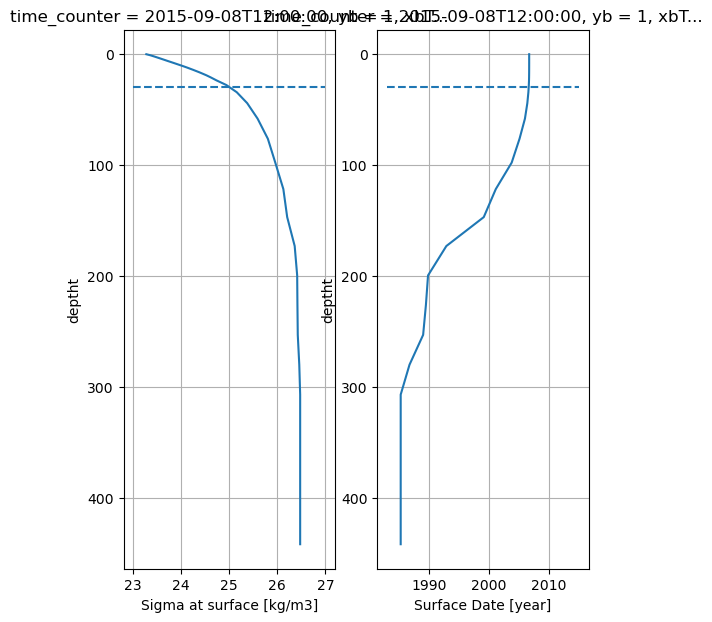

In [7]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.sigma[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.pycnal_last_at_surface[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([23, 27], [30, 30], '--', color='tab:blue')
axs[1].plot([1983, 2015], [30, 30], '--', color='tab:blue');

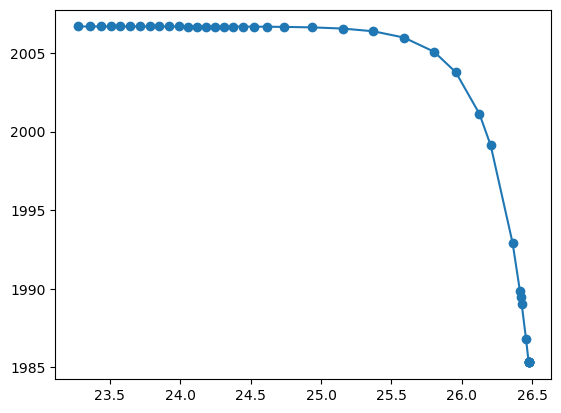

In [8]:
#plot
plt.plot(ds.sigma[0, :, 0, 10], ds.pycnal_last_at_surface[0, :, 0, 10], 'o-');

## Step 2 Find pCO2 at Surface that Year ##

In [9]:
# check it out
co2_rec = pd.read_csv('../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/lawdome_maunaloa.csv')
print (co2_rec)
years = [1833.2, 1932, 2017]
for year in years:
    print (co2_rec.iloc[np.argmin(np.abs(co2_rec['YEAR'] - year))]['PPMCO2'])

     YEAR  PPMCO2 Unnamed: 2
0    1832  284.30           
1    1833  284.10           
2    1834  284.00           
3    1835  283.80           
4    1836  283.70           
..    ...     ...        ...
182  2014  398.65        NaN
183  2015  400.83        NaN
184  2016  404.24        NaN
185  2017  406.55        NaN
186  2018  408.52        NaN

[187 rows x 3 columns]
284.1
308.2
406.55


In [10]:
# two functions to help calculate atpco2
def co2_from_year_init():
    co2_rec = pd.read_csv('../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/lawdome_maunaloa.csv')
    sindex = co2_rec[co2_rec['YEAR'] == 1950].index.values[0]
    co2_rec = co2_rec.set_index('YEAR')
    c = np.polynomial.Polynomial.fit(co2_rec.index[sindex:], co2_rec.PPMCO2[sindex:], deg=2)
    return c

def co2_from_year(ds, c):
    if (np.min(ds.pycnal_last_at_surface.values) < 1950) | (np.max(ds.pycnal_last_at_surface.values) > 2025):
        print ('Years asked for are out of range of fit!', np.min(ds.pycnal_last_at_surface.values),
              np.max(ds.pycnal_last_at_surface.values))
    ds = ds.assign(atpco2=ds.pycnal_last_at_surface)
    ds.atpco2[:] = c(ds.pycnal_last_at_surface.values)
    return ds

In [11]:
# Calculate the Atmospheric CO2 when watermass was at surface atpco2
c = co2_from_year_init()
ds = co2_from_year(ds, c)  # uses the Mauna Loa look up
ds.atpco2.attrs['long_name'] = 'Atmospheric pCO2'
ds.atpco2.attrs['units'] = 'ppm'

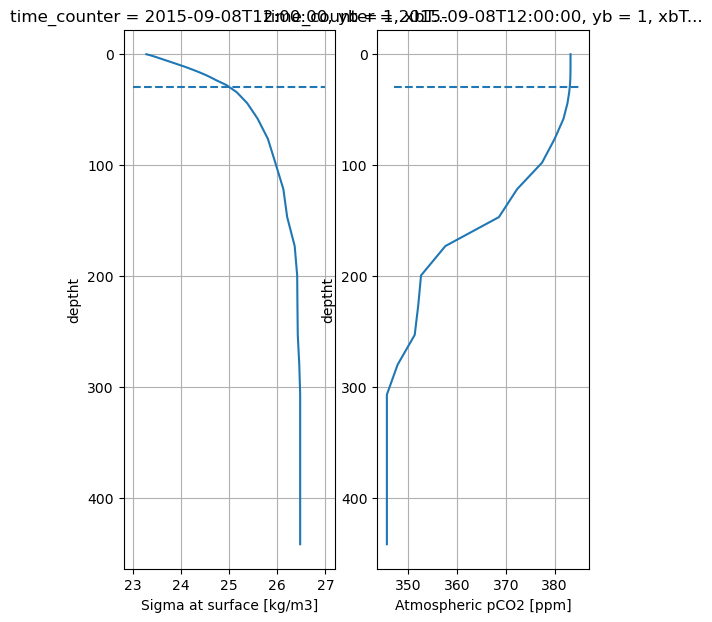

In [12]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.sigma[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.atpco2[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([23, 27], [30, 30], '--', color='tab:blue')
axs[1].plot([347, 385], [30, 30], '--', color='tab:blue');

Less kinks than Tereza as I have no year truncation.

## Step 3 Find AOU for Water Masses ##

In [13]:
# calculate saturated oxygen value
# pressure is ds.deptht

ds['osol'] = gsw.O2sol(ds.vosaline, ds.votemper, ds.deptht, lon=-125, lat=50)
ds.osol.attrs['long_name'] = 'oxygen solubility'
ds.osol.attrs['units'] = 'umol/kg'

# for testing, compare to ignore pressure affect
osol0 = gsw.O2sol(ds.vosaline, ds.votemper, 0.*ds.deptht, lon=-125, lat=50)

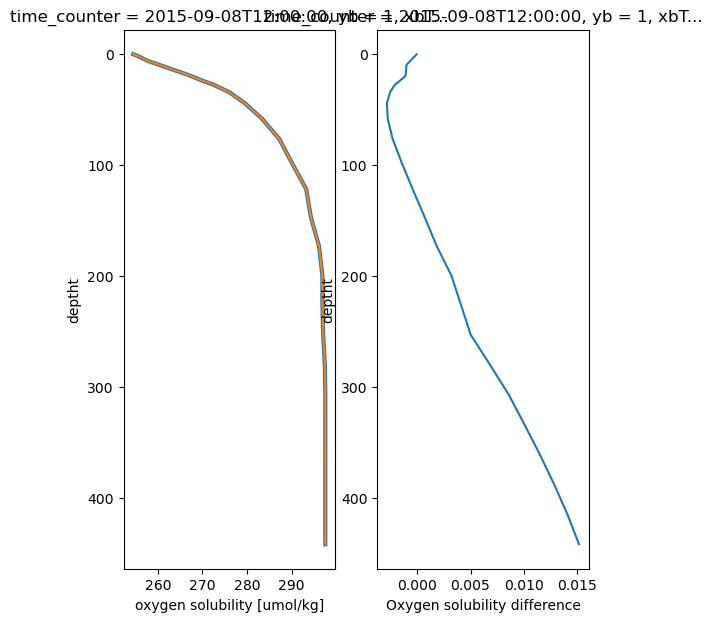

In [14]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
osol0[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, linewidth=3);
ds.osol[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False);
(ds.osol[0, :, 0, 10] - osol0[0, :, 0, 10]).plot(ax=axs[1], y='deptht', yincrease=False);
axs[1].set_xlabel('Oxygen solubility difference');

In [15]:
# calculate AOU in umol/kg
ds['AOU'] = ds.osol - ds.OXY
ds.AOU.attrs['long_name'] = 'apparent oxygen utilization'
ds.AOU.attrs['units'] = 'umol/kg'

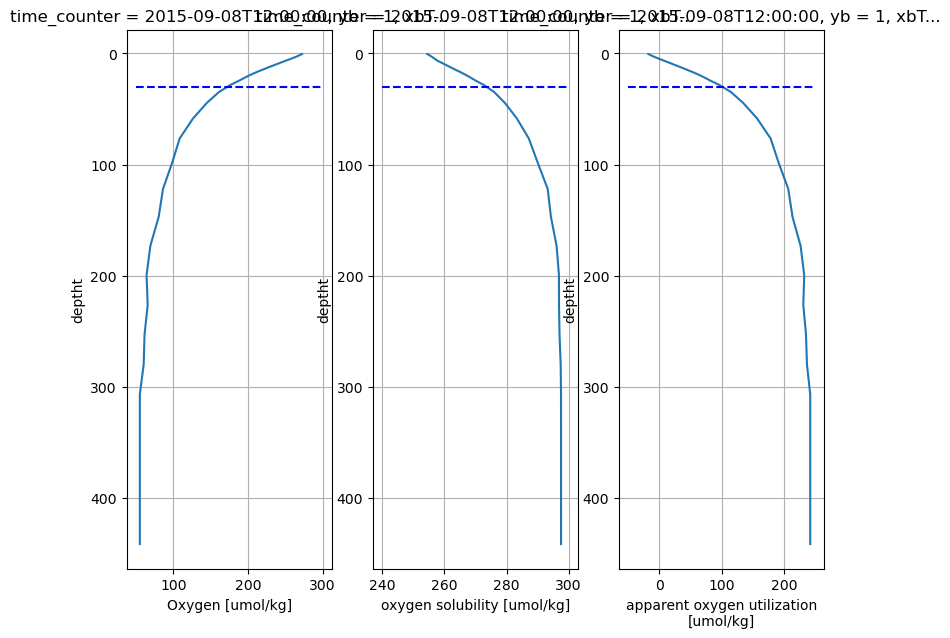

In [16]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(15/5*3, 7))
ds.OXY[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.osol[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);
ds.AOU[0, :, 0, 10].plot(ax = axs[2], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([50, 300], [30, 30], '--', color='b')
axs[1].plot([240, 300], [30, 30], '--', color='b');
axs[2].plot([-50, 250], [30, 30], '--', color='b');

## Debby question! ##
*Answer: quickly yes, we would expect a different ratio than Redfield (Anderson & Sarmiento, 1994)*  
Anderson, L. A., & Sarmiento, J. L. (1994). Redfield ratios of remineralization determined by nutrient data analysis. Global Biogeochemical Cycles, 8(1), 65â€“80. https://doi.org/10.1029/93GB03318


In [17]:
# Carbon to oxygen 117:170. rather than 106:138?
print (170/117, 138/106)

1.452991452991453 1.3018867924528301


In [18]:
# estimate inorganic carbon  produced by AOU
ds['AOU_stoich'] = ds.AOU * (117/170)
ds.AOU_stoich.attrs['long_name'] = 'oxygen solubility in carbon units'
ds.AOU_stoich.attrs['units'] = 'umol C/kg'

## Step 4 Find preformed DIC ##

In [19]:
# calculate preformed DIC
ds['preformed_DIC'] = ds.DIC - ds.AOU_stoich
ds.preformed_DIC.attrs['long_name'] = 'preformed dissolved inorganic carbon'
ds.preformed_DIC.attrs['units'] = 'umol/kg'

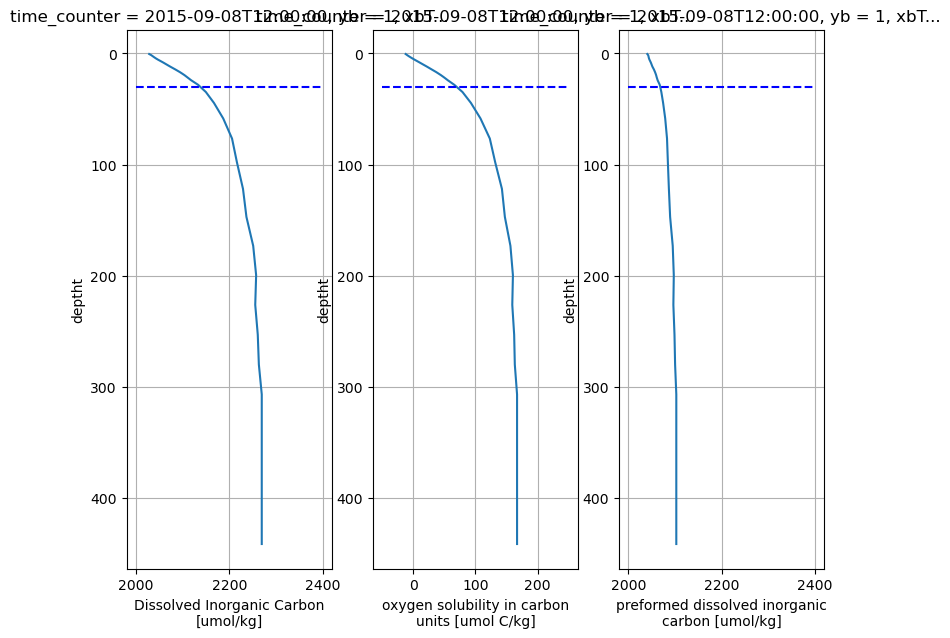

In [20]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(15/5*3, 7))
ds.DIC[0, :, 0, 10].plot(ax = axs[0], y='deptht', yincrease=False);
ds.AOU_stoich[0, :, 0, 10].plot(ax = axs[1], y='deptht', yincrease=False);
ds.preformed_DIC[0, :, 0, 10].plot(ax = axs[2], y='deptht', yincrease=False);

for ax in axs:
    ax.grid();
axs[0].plot([2000, 2400], [30, 30], '--', color='b')
axs[1].plot([-50, 250], [30, 30], '--', color='b');
axs[2].plot([2000, 2400], [30, 30], '--', color='b');

## Step 4 Find Preformed pCO2 ##

Use CO2sys as we need to go back as well and need to be consistent

https://pyco2sys.readthedocs.io/en/latest/

and in particular example 2  https://github.com/mvdh7/PyCO2SYS-examples/blob/master/CO2SYSExample2.ipynb

In [21]:
# Translate Salinity and Conservative Temperature to psu and potential temperature
ds['psu'] = gsw.SP_from_SA(ds.vosaline, p=0*ds.vosaline, lat=49, lon=-126)
ds['pottemp'] = gsw.pt_from_CT(ds.vosaline, ds.votemper)
# Define input and output conditions
kwargs = dict(
    par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
    par1 = ds.TA.values,  # value of the first parameter
    par2_type = 2,  # The second parameter supplied is of type "2", which means "DIC"
    par2 = ds.preformed_DIC.values,
    salinity = ds.psu.values,  # Salinity of the sample
    temperature = ds.pottemp.values,  # Temperature at input conditions 
    total_silicate = 0*ds.Si.values * conversion_uMolar_to_umolkg,  # Concentration of silicate  in the sample (in umol/kg)
    total_phosphate = 0*ds.NO3.values * conversion_uMolar_to_umolkg * 1/16.,  # Concentration of phosphate in the sample (in umol/kg)
    opt_k_carbonic = 14,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("14" means Millero 2010")
                          # I checked this in the code
    opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4 ("1" means "Dickson")
    opt_total_borate = 2,  # Choice of boron:sal ("2" means "LKB10"). # Lee et al what Mucci
    opt_k_fluoride = 1,
    opt_pressured_kCO2 = 1
)
print('Conditions have been defined!')

Conditions have been defined!


In [22]:
# calculate preformed pCO2 - when water was last at surface, ocean pCO2
results_pCO2 = pyco2.sys(**kwargs)
ds = ds.assign(preformed_pco2= 0.*ds['atpco2'])
ds.preformed_pco2[:] = results_pCO2['pCO2']
ds.preformed_pco2.attrs['long_name'] = 'preformed Surface pCO2'
ds.preformed_pco2.attrs['units'] = 'uatm'

68.9881470582269


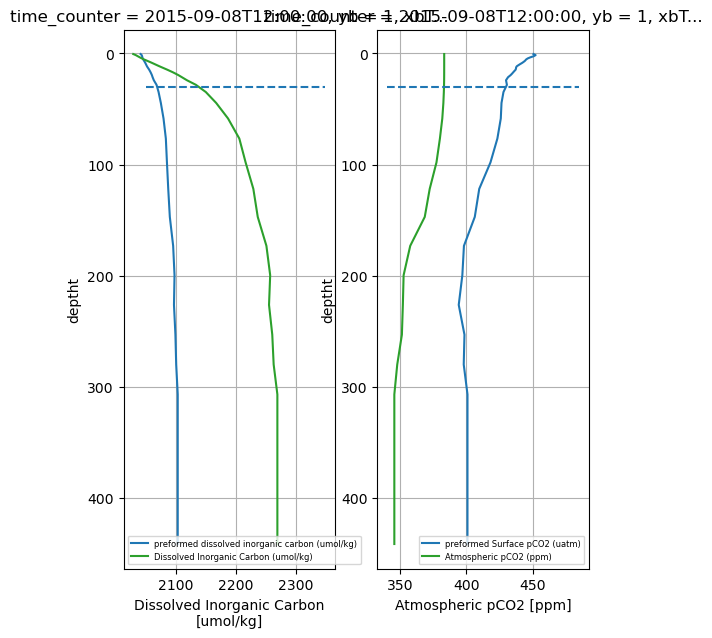

In [23]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.preformed_DIC[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, 
                        label=f'{ds.preformed_DIC.attrs["long_name"]} ({ds.preformed_DIC.attrs["units"]})')           
ds.DIC[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:green', 
                         label=f'{ds.DIC.attrs["long_name"]} ({ds.DIC.attrs["units"]})')
ds.preformed_pco2[0, :, 0, 10].plot(ax=axs[1], y='deptht', yincrease=False, 
                                    color='tab:blue', 
                        label=f'{ds.preformed_pco2.attrs["long_name"]} ({ds.preformed_pco2.attrs["units"]})')
ds.atpco2[0, :, 0, 10].plot(ax=axs[1], y='deptht', yincrease=False, color='tab:green',
                         label=f'{ds.atpco2.attrs["long_name"]} ({ds.atpco2.attrs["units"]})');

for ax in axs:
    ax.grid();
    ax.legend(prop={'size': 6});
axs[0].plot([2050, 2350], [30, 30], '--', color='tab:blue')
axs[1].plot([340, 485], [30, 30], '--', color='tab:blue');

print (np.max(ds.preformed_pco2[0, :, 0, 10] - ds.atpco2[0, :, 0, 10]).values)

Quite a big difference but early September is probably near maximum

## Step 5 Find Dis-equilibrium pCO2 ##


In [24]:
# calculate disequilibrium pCO2
ds['diseqPCO2'] = ds.preformed_pco2 - ds.atpco2
ds.diseqPCO2.attrs['long_name'] = 'ocean - atm, disequilibrium pCO2'
ds.diseqPCO2.attrs['units'] = 'uatm'

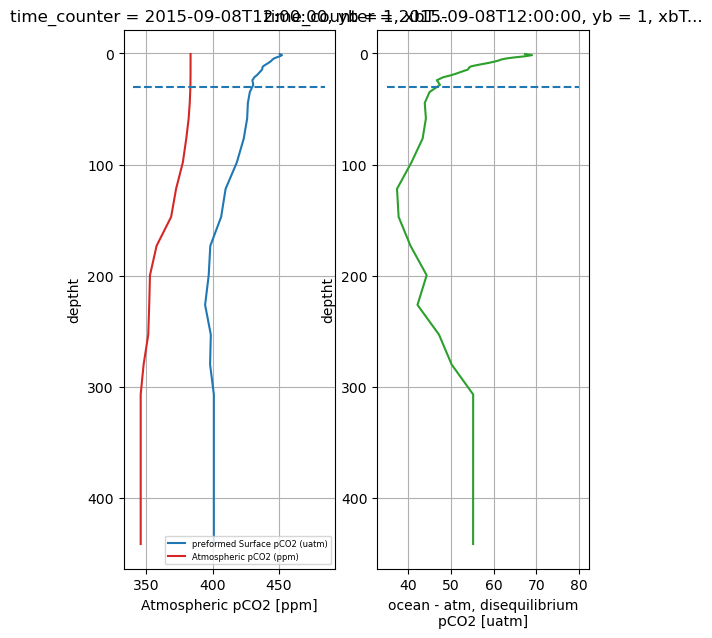

In [25]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15/5*2, 7))
ds.preformed_pco2[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:blue',
                        label=f'{ds.preformed_pco2.attrs["long_name"]} ({ds.preformed_pco2.attrs["units"]})')
ds.atpco2[0, :, 0, 10].plot(ax=axs[0], y='deptht', yincrease=False, color='tab:red',
                         label=f'{ds.atpco2.attrs["long_name"]} ({ds.atpco2.attrs["units"]})');   

ds.diseqPCO2[0, :, 0, 10].plot(ax=axs[1], y='deptht', yincrease=False, color='tab:green');

for ax in axs:
    ax.grid();
axs[0].legend(prop={'size': 6});
axs[0].plot([340, 485], [30, 30], '--', color='tab:blue')
axs[1].plot([35, 80], [30, 30], '--', color='tab:blue');

## Step 6 Find PI preformed pCO2 (including disequilbrium ##


In [26]:
# add the PI atmospheric pCO2
ds['PIpref_pco2_inc_diseqpco2'] = ds.diseqPCO2 + 284
ds.PIpref_pco2_inc_diseqpco2.attrs['long_name'] = 'PI preformed pCO2 including disequilbrium'
ds.PIpref_pco2_inc_diseqpco2.attrs['units'] = 'uatm'

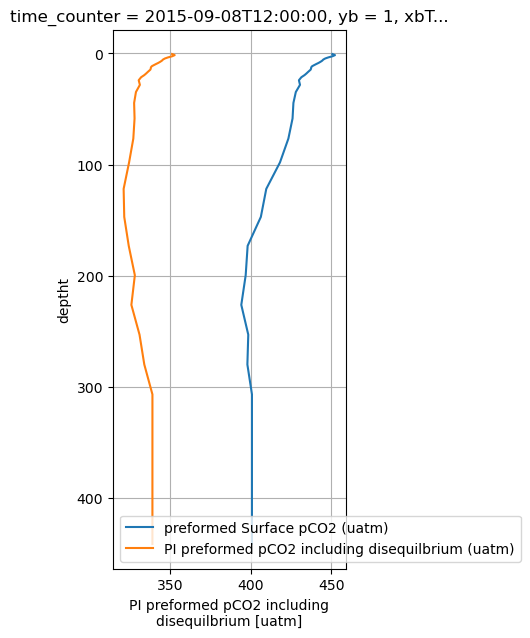

In [27]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.preformed_pco2[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
            label=f'{ds.preformed_pco2.attrs["long_name"]} ({ds.preformed_pco2.attrs["units"]})')                       
ds.PIpref_pco2_inc_diseqpco2[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, 
                                               color='tab:orange',
            label=f'{ds.PIpref_pco2_inc_diseqpco2.attrs["long_name"]} ({ds.PIpref_pco2_inc_diseqpco2.attrs["units"]})')
ax.grid();
ax.legend()
axs[0].plot([340, 485], [30, 30], '--', color='tab:blue');

## Step 7 Find PI preformed DIC (including disequilbrium) ##

In [28]:
# Define input and output conditions
kwargs = dict(
    par1_type = 1,  # The first parameter supplied is of type "1", which means "alkalinity"
    par1 = ds.TA.values,  # value of the first parameter
    par2_type = 4,  # The second parameter supplied is of type "4", which means "pCO2"
    par2 = ds.PIpref_pco2_inc_diseqpco2.values,  # value of the second parameter
    salinity = ds.psu.values,  # Salinity of the sample
    temperature = ds.pottemp.values,  # Temperature at input conditions 
    total_silicate = 0*ds.Si.values * conversion_uMolar_to_umolkg,  # Concentration of silicate  in the sample (in umol/kg)
    total_phosphate = 0*ds.NO3.values * conversion_uMolar_to_umolkg * 1/16.,  # Concentration of phosphate in the sample (in umol/kg)
    opt_k_carbonic = 14,  # Choice of H2CO3 and HCO3- dissociation constants K1 and K2 ("14" means Millero 2010")
    opt_k_bisulfate = 1,  # Choice of HSO4- dissociation constant KSO4 ("1" means "Dickson")
    opt_total_borate = 2,  # Choice of boron:sal ("2" means "LKB10")
    opt_k_fluoride = 1,
    opt_pressured_kCO2 = 1
)
print('Conditions have been defined!')

Conditions have been defined!


In [29]:
# Calculate preformed DIC
dic_results = pyco2.sys(**kwargs)

ds = ds.assign(preind_pref_dic= 0.*ds['atpco2'])
ds.preind_pref_dic[:] = dic_results['dic']
ds.preind_pref_dic.attrs['long_name'] = 'PI preformed DIC'
ds.preind_pref_dic.attrs['units'] = 'umol/kg'

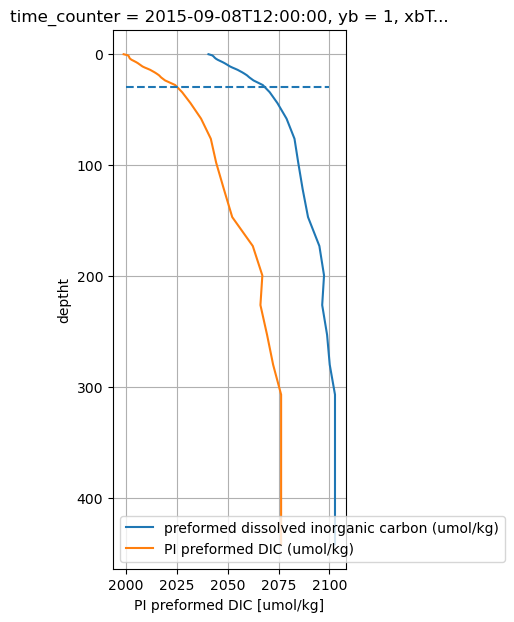

In [30]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.preformed_DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
                            label=f'{ds.preformed_DIC.attrs["long_name"]} ({ds.preformed_DIC.attrs["units"]})')
ds.preind_pref_dic[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:orange',
                            label=f'{ds.preind_pref_dic.attrs["long_name"]} ({ds.preind_pref_dic.attrs["units"]})')

ax.grid();
ax.legend()
ax.plot([2000, 2100], [30, 30], '--', color='tab:blue');

## Step 8 Find Delta DIC ##

In [31]:
# Calculate delta DIC
ds['deltaDIC'] = ds.preformed_DIC - ds.preind_pref_dic
ds.deltaDIC.attrs['long_name'] = 'Delta preformed DIC: Current - PI'
ds.deltaDIC.attrs['units'] = 'umol/kg'

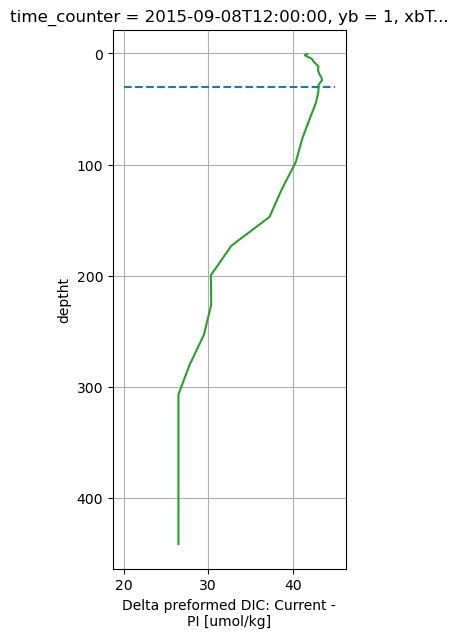

In [32]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.deltaDIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:green',
                                   );
ax.grid();
ax.plot([20, 45], [30, 30], '--', color='tab:blue');

## Step 9 : Final PI DIC ##

In [33]:
# find PI DIC in uMol
ds['Final_PI_DIC'] = (ds.DIC - ds.deltaDIC) / conversion_uMolar_to_umolkg
ds.Final_PI_DIC.attrs['long_name'] = 'PI Dissolved Inorganic Carbon'
ds.Final_PI_DIC.attrs['units'] = 'uMol'

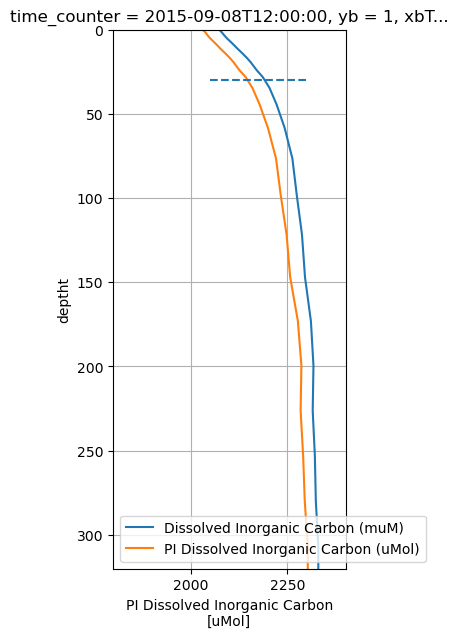

In [34]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.DIC_uMol[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
                                   label=f'{ds.DIC_uMol.attrs["long_name"]} ({ds.DIC_uMol.attrs["units"]})')
ds.Final_PI_DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:orange',
                                    label=f'{ds.Final_PI_DIC.attrs["long_name"]} ({ds.Final_PI_DIC.attrs["units"]})')

ax.grid();
ax.legend()
ax.set_xlim(1800, 2400)
ax.set_xticks([2000, 2250])
ax.set_ylim(320, 0)
ax.plot([2050, 2300], [30, 30], '--', color='tab:blue');

##  Compare to Tereza's ##

Tereza's value for September 
![title](../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/September.png)

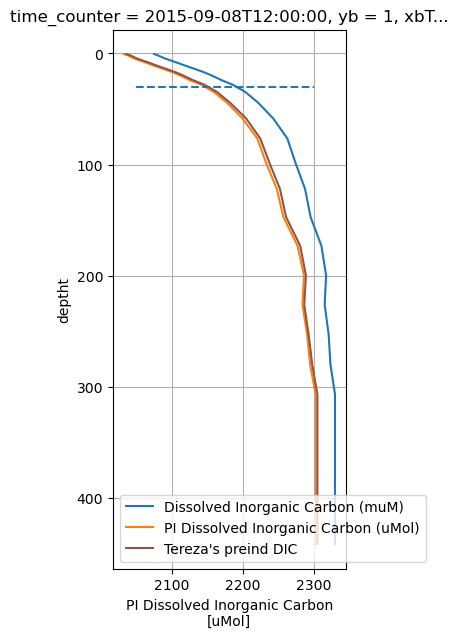

In [35]:
# plot
tj = xr.open_dataset('../../../analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/preind_DIC/LO_AOUmethod_stoicCO_diseq_allup_y2015m09d08_preind_DIC.nc',
                    group='preindustrial_DIC')

fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.DIC_uMol[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
                                   label=f'{ds.DIC_uMol.attrs["long_name"]} ({ds.DIC_uMol.attrs["units"]})')
ds.Final_PI_DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:orange',
                                    label=f'{ds.Final_PI_DIC.attrs["long_name"]} ({ds.Final_PI_DIC.attrs["units"]})')

ax.plot(tj.preind_dic[:, 10], ds.deptht, color='tab:brown',
                          label="Tereza's preind DIC")
                          
ax.grid();
ax.legend()
ax.plot([2050, 2300], [30, 30], '--', color='tab:blue');

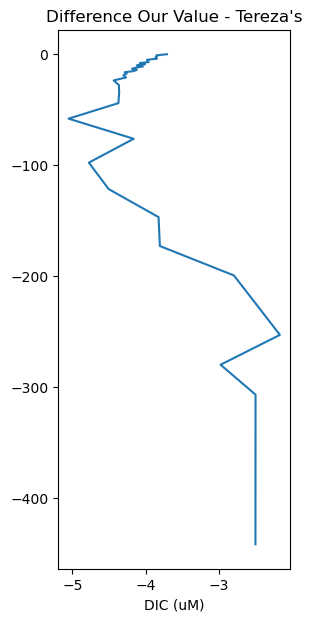

In [36]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ax.plot(ds.Final_PI_DIC[0, :, 0, 10].values - tj.preind_dic[:, 10].values, -ds.deptht)
ax.set_title("Difference Our Value - Tereza's");
ax.set_xlabel("DIC (uM)");

## Step 10: Correct Near Surface Values

From Tereza's paper or thesis:  
*The cfc tracer method is not appropriate for very young waters, so we do not use it for lower-density waters (σθ <25.0). These lower density waters are typically recently-ventilated waters found near the surface and are likely to be tracking the current atmospheric CO2 concentrations. I used a surface intrusion value of 60 mmol m−3 for these waters (σθ <25.0); this estimate is within the range of the reported surface values for the shelf values in the region based on (Feely et al., 2016) and the broader open Pacific (Carter et al., 2019). To avoid discontinuities in the carbon field, for every depth profile I then linearly interpolated from a value of 60 mmol m−3 at surface to the value at σθ =25.0.*

In [37]:
# check it out
print (ds.Final_PI_DIC[0, :, 0, 10][ds.deptht < 30.06])

<xarray.DataArray 'Final_PI_DIC' (deptht: 22)> Size: 176B
array([2032.71843856, 2037.56428901, 2040.96013159, 2044.19837563,
       2047.75418559, 2051.8043605 , 2056.3296279 , 2060.83865342,
       2065.18444218, 2069.31675187, 2073.49217601, 2077.69547719,
       2082.20024263, 2086.85246835, 2091.54429336, 2096.04754533,
       2100.8453764 , 2105.63006888, 2111.10135187, 2117.21122248,
       2125.98496718, 2142.23899591])
Coordinates:
    time_counter  datetime64[ns] 8B 2015-09-08T12:00:00
  * deptht        (deptht) float64 176B 0.5 1.5 2.5 3.5 ... 21.39 24.1 28.23
    yb            int64 8B 1
    xbT           int64 8B 10
Attributes:
    long_name:  PI Dissolved Inorganic Carbon
    units:      uMol


In [38]:
# doing this in uMol, so convert deltaDIC
ds['deltaDIC_uMol'] = ds.deltaDIC / conversion_uMolar_to_umolkg
ds.deltaDIC_uMol.attrs['long_name'] = ds.deltaDIC.attrs['long_name']
ds.deltaDIC_uMol.attrs['units'] = 'uMol'

In [39]:
# Calculate: I don't love this, it has a loop
surf_intrusion = 60 # uM
sigma_crit = 25 # Value where we switch from surface intrusion to tracked age
ds = ds.assign(PI_DIC_surfacj= 0 + 1 * ds['Final_PI_DIC'])
ds.PI_DIC_surfacj.attrs['long_name'] = 'PI DIC with Surface Adjustment'
ds.PI_DIC_surfacj.attrs['units'] = 'uMol'

depth_crit = np.zeros(ds.sigma.shape[3])
intrusion_at_crit = np.zeros_like(depth_crit)
intrusion_values = np.zeros((ds.sigma.shape[1], ds.sigma.shape[3]))
for ii in range(ds.sigma.shape[3]):
    depth_crit[ii] = np.interp(sigma_crit, ds.sigma[0, :, 0, ii], ds.deptht.values)
    intrusion_at_crit[ii] = np.interp(sigma_crit, ds.sigma[0, :, 0, ii], ds.deltaDIC_uMol[0, :, 0, ii])
    intrusion_values[:, ii] = (surf_intrusion * (1 - ds.deptht / depth_crit[ii]) 
                               + intrusion_at_crit[ii] * ds.deptht / depth_crit[ii]);
    kk_crit = np.argmax(ds.deptht.values > depth_crit[ii])
    ds.PI_DIC_surfacj[0, :, 0, ii][ds.deptht < depth_crit[ii]] = (ds.DIC_uMol[0, :, 0, ii][ds.deptht < depth_crit[ii]] 
                                                              - intrusion_values[:kk_crit, ii])

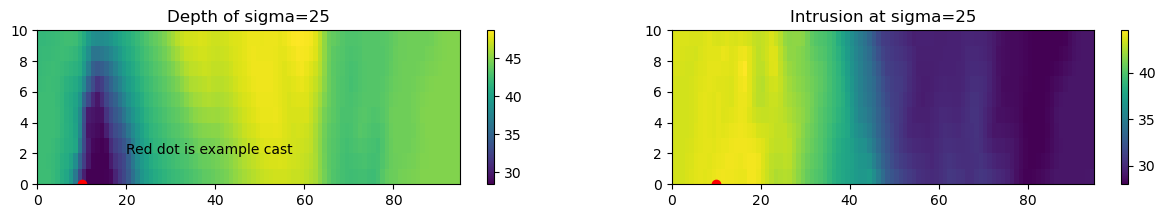

In [40]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15, 2))
colours = axs[0].pcolormesh(depth_crit.reshape(10, 95))
fig.colorbar(colours, ax=axs[0]);
colours = axs[1].pcolormesh(intrusion_at_crit.reshape(10, 95))
fig.colorbar(colours, ax=axs[1]);
for ax in axs:
    ax.plot(10, 0, 'ro');
axs[0].set_title("Depth of sigma=25")
axs[1].set_title("Intrusion at sigma=25")
axs[0].text(20, 2, "Red dot is example cast");

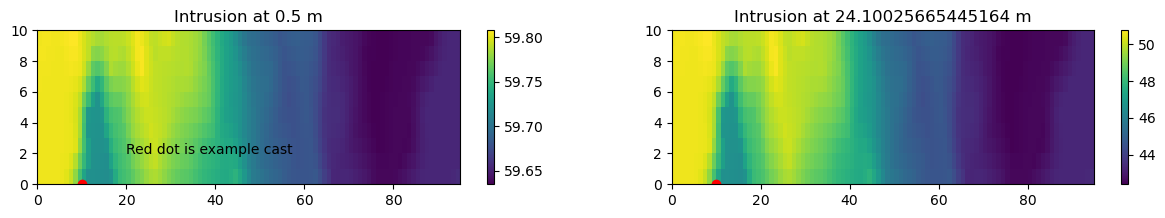

In [41]:
# plot
fig, axs = plt.subplots(1, 2, figsize=(15, 2))
colours = axs[0].pcolormesh(intrusion_values[0].reshape(10, 95))
fig.colorbar(colours, ax=axs[0]);
colours = axs[1].pcolormesh(intrusion_values[20].reshape(10, 95))
fig.colorbar(colours, ax=axs[1]);
for ax in axs:
    ax.plot(10, 0, 'ro');
axs[0].set_title("Intrusion at 0.5 m")
axs[1].set_title(f'Intrusion at {ds.deptht[20].values} m')
axs[0].text(20, 2, "Red dot is example cast");

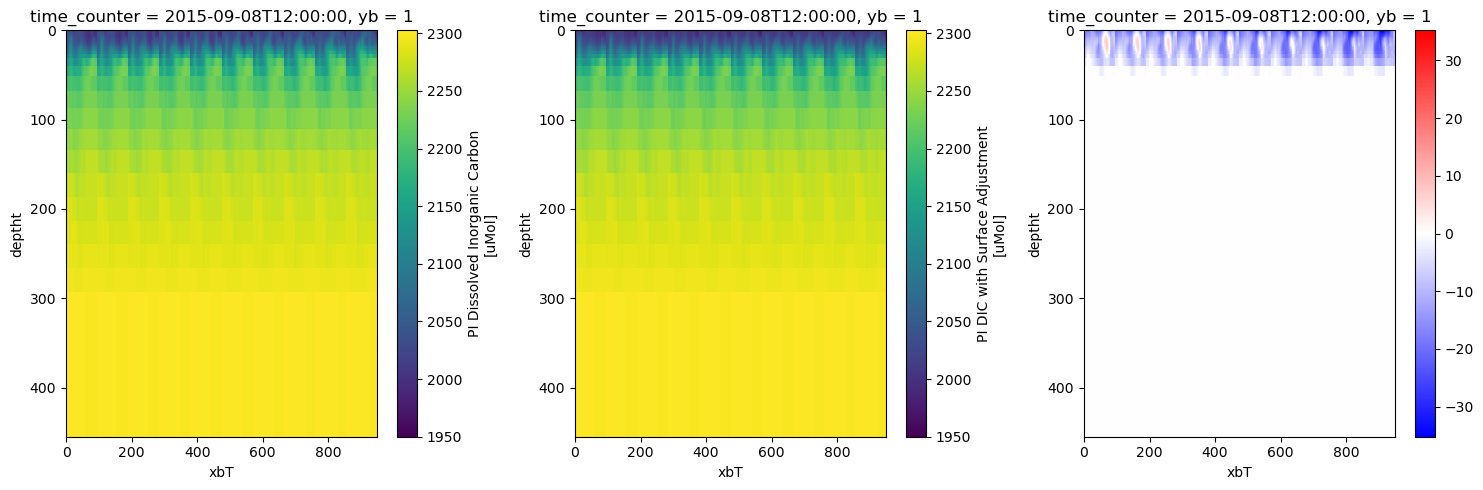

In [42]:
# plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ds['Final_PI_DIC'][0, :, 0, :].plot(y='deptht', yincrease=False, ax=axs[0], vmin=1950)
ds['PI_DIC_surfacj'][0, :, 0, :].plot(y='deptht', yincrease=False, ax=axs[1], vmin=1950)
(ds['PI_DIC_surfacj'][0, :, 0, :]-ds['Final_PI_DIC'][0, :, 0, :]).plot(y='deptht', yincrease=False, ax=axs[2],
                                                                      cmap='bwr')
fig.tight_layout();

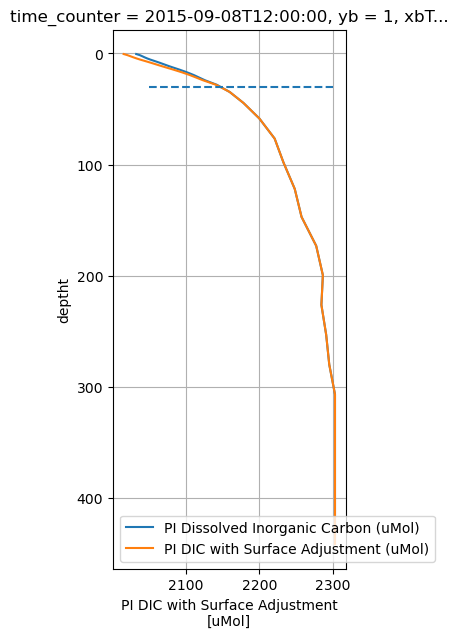

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15/5*1, 7))
ds.Final_PI_DIC[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:blue',
                                   label=f'{ds.Final_PI_DIC.attrs["long_name"]} ({ds.Final_PI_DIC.attrs["units"]})')
ds.PI_DIC_surfacj[0, :, 0, 10].plot(ax=ax, y='deptht', yincrease=False, color='tab:orange',
                                    label=f'{ds.PI_DIC_surfacj.attrs["long_name"]} ({ds.PI_DIC_surfacj.attrs["units"]})')
                          
ax.grid();
ax.legend()
ax.plot([2050, 2300], [30, 30], '--', color='tab:blue');

In [44]:
# check it out
print (ds['PI_DIC_surfacj'][0, :, 0, 10])

<xarray.DataArray 'PI_DIC_surfacj' (deptht: 40)> Size: 320B
array([2015.65262226, 2020.74759807, 2024.85464357, 2028.95642553,
       2033.31379358, 2038.04715289, 2043.16829532, 2048.30651593,
       2053.30527061, 2058.12257956, 2062.97245219, 2067.8416052 ,
       2072.89954418, 2078.03927787, 2083.24910529, 2088.36971339,
       2093.8171523 , 2099.31800179, 2105.65624881, 2112.96502387,
       2123.2461091 , 2141.27369707, 2159.65389935, 2178.23622534,
       2199.78985686, 2220.57696378, 2232.53918125, 2247.84773954,
       2257.09852726, 2276.98038856, 2286.04071394, 2284.0336598 ,
       2290.50293693, 2294.70150881, 2302.48491101, 2302.48464283,
       2302.4843818 , 2302.48413884, 2302.48391362, 2302.48371602])
Coordinates:
    time_counter  datetime64[ns] 8B 2015-09-08T12:00:00
  * deptht        (deptht) float64 320B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    yb            int64 8B 1
    xbT           int64 8B 10
Attributes:
    long_name:  PI DIC with Surface Adjustment
    

In [45]:
# check it out
print (ds['Final_PI_DIC'][0, :, 0, 10])

<xarray.DataArray 'Final_PI_DIC' (deptht: 40)> Size: 320B
array([2032.71843856, 2037.56428901, 2040.96013159, 2044.19837563,
       2047.75418559, 2051.8043605 , 2056.3296279 , 2060.83865342,
       2065.18444218, 2069.31675187, 2073.49217601, 2077.69547719,
       2082.20024263, 2086.85246835, 2091.54429336, 2096.04754533,
       2100.8453764 , 2105.63006888, 2111.10135187, 2117.21122248,
       2125.98496718, 2142.23899591, 2159.65389935, 2178.23622534,
       2199.78985686, 2220.57696378, 2232.53918125, 2247.84773954,
       2257.09852726, 2276.98038856, 2286.04071394, 2284.0336598 ,
       2290.50293693, 2294.70150881, 2302.48491101, 2302.48464283,
       2302.4843818 , 2302.48413884, 2302.48391362, 2302.48371602])
Coordinates:
    time_counter  datetime64[ns] 8B 2015-09-08T12:00:00
  * deptht        (deptht) float64 320B 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    yb            int64 8B 1
    xbT           int64 8B 10
Attributes:
    long_name:  PI Dissolved Inorganic Carbon
    uni

Tereza's files at: /ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER/PI_BOUND_COND/CLEAN/preind_DIC